## Todos

- calculate centrality measure only once
- replace randomize_graph in basic_graph_analyzer.py by utils function

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer


In [2]:
from graph_tool import openmp_set_num_threads

# Set the number of threads to use
openmp_set_num_threads(8)

In [3]:
from graph_tool.all import load_graph

file_path = 'outputs/graphs/Amiga_CD32_games.gt'

G = load_graph(file_path)

num_nodes = G.num_vertices()
num_edges = G.num_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 8013
Number of edges: 1537410


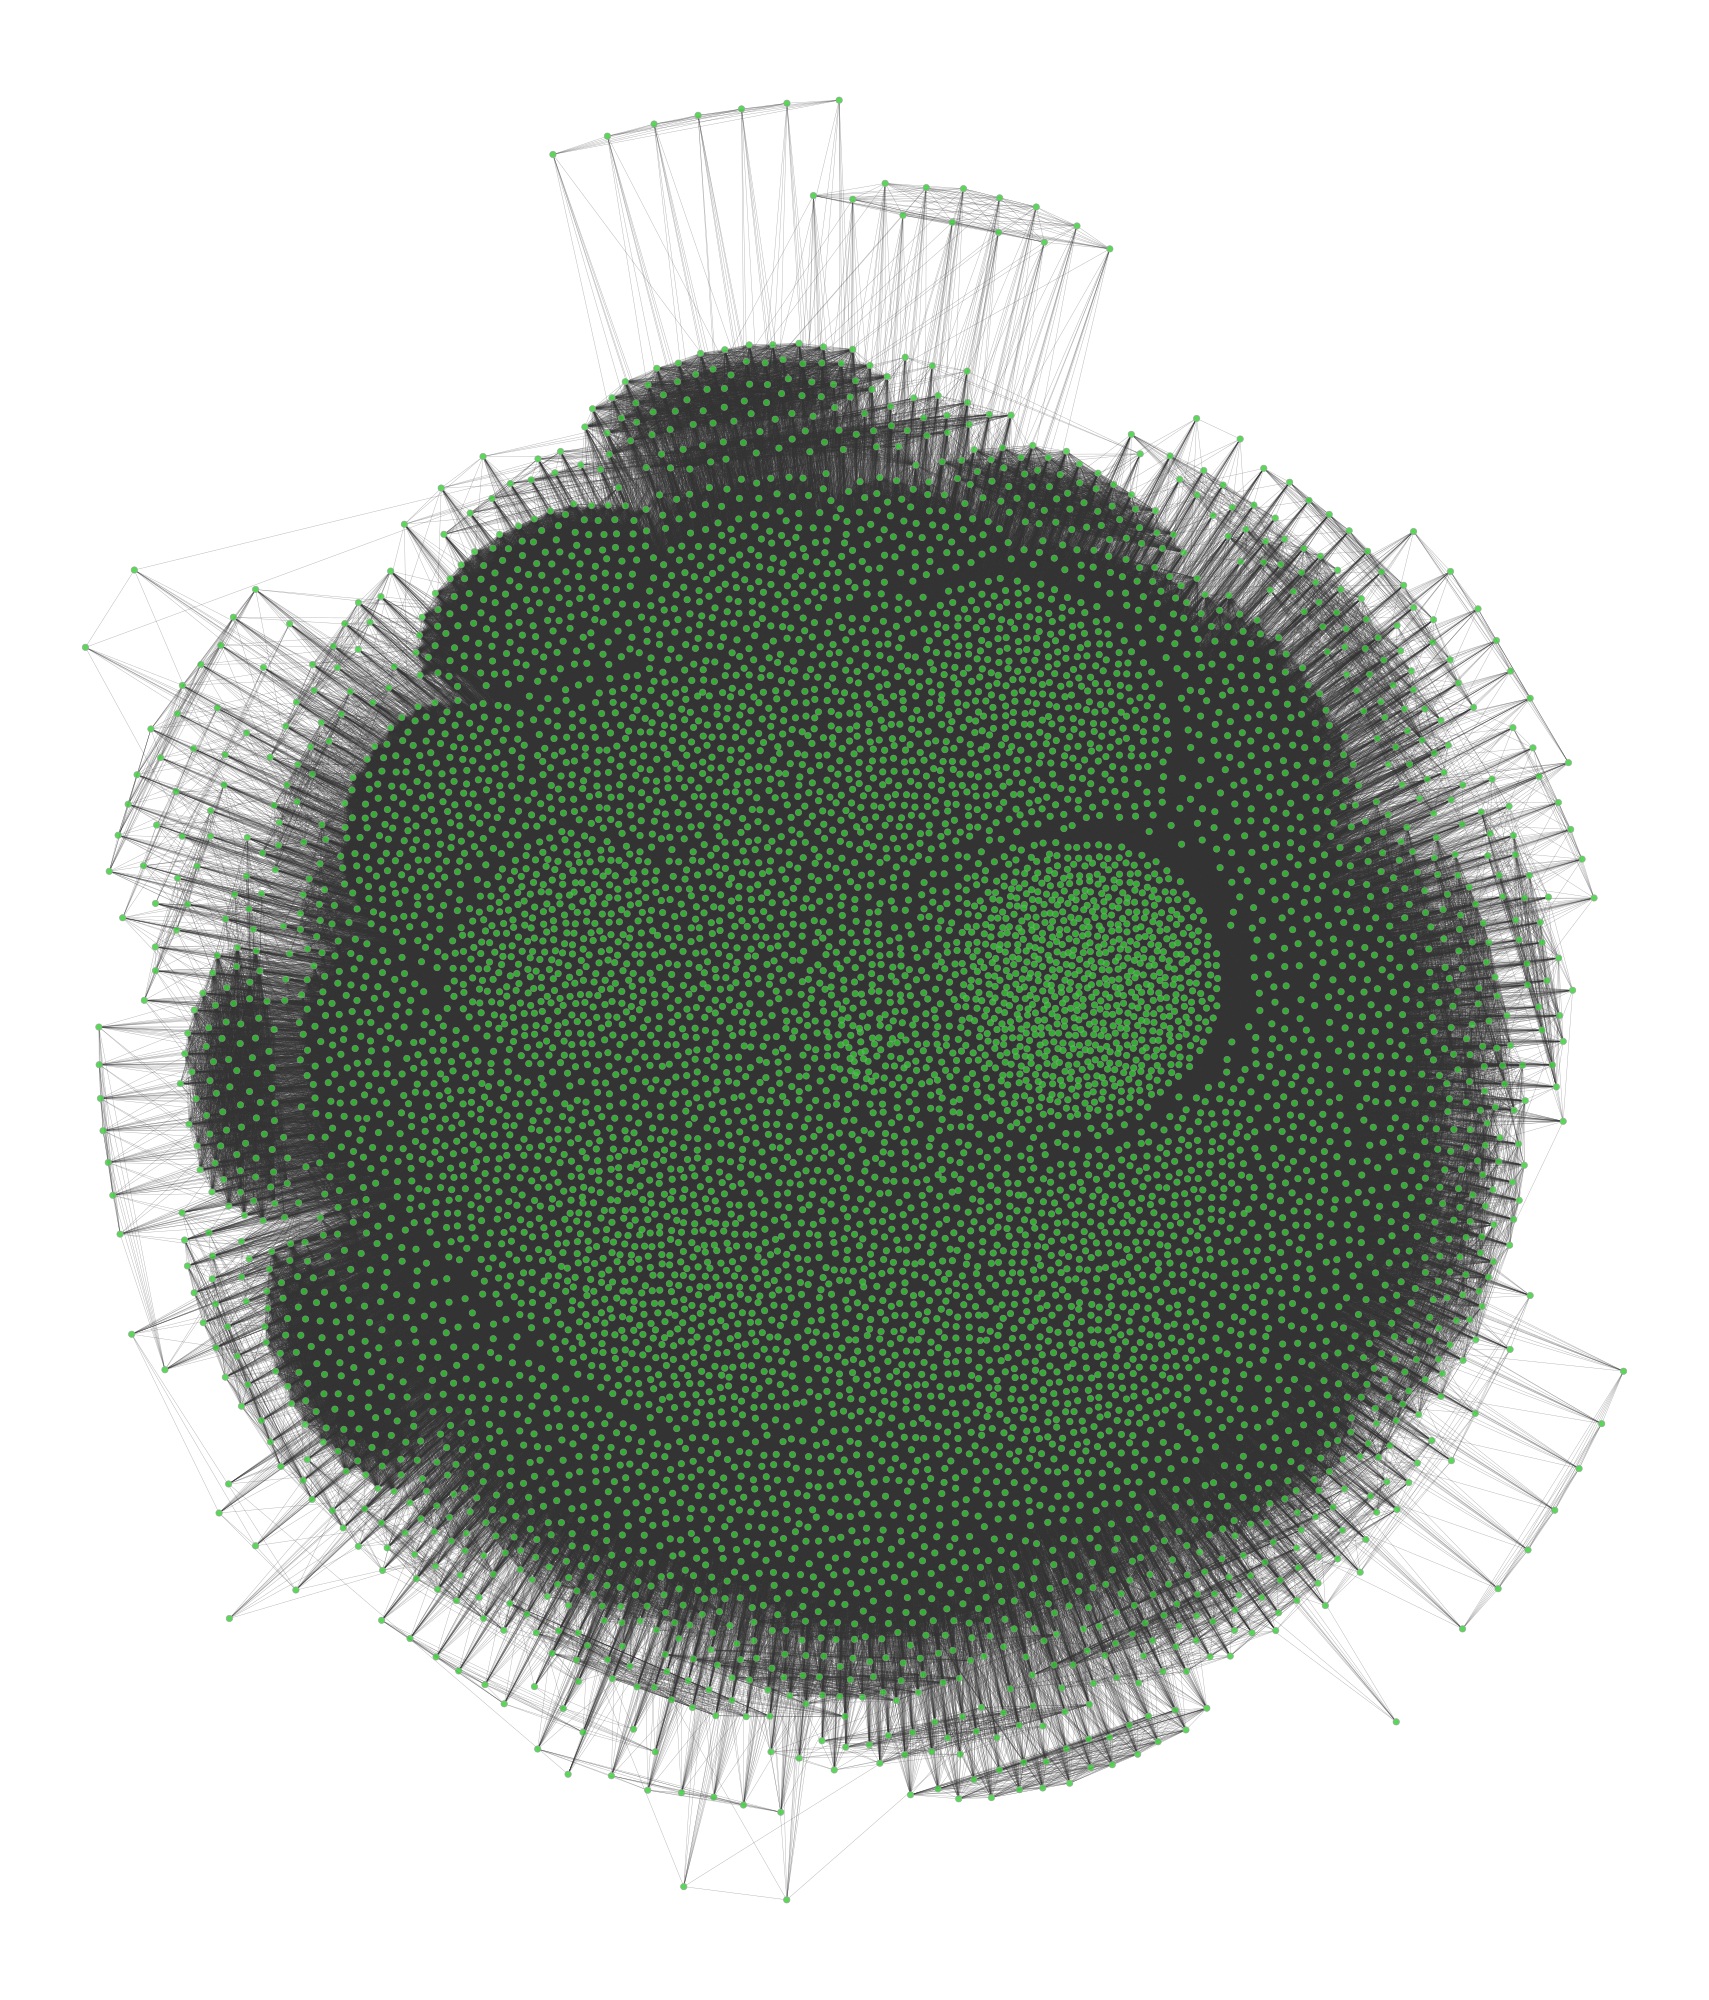

In [6]:
import graph_tool.all as gt
import numpy as np
from graph_tool.draw import sfdp_layout, graph_draw
import numpy as np
from graph_tool.draw import sfdp_layout, graph_draw
import numpy as np
from graph_tool.draw import sfdp_layout, graph_draw
import graph_tool.all as gt  # Need this for clustering coefficient
import numpy as np

def viz_with_better_clustering(g):
    clustering = gt.local_clustering(g)
    
    # Get distribution info to set better thresholds
    clust_vals = np.array([clustering[v] for v in g.vertices()])
    low_threshold = np.percentile(clust_vals, 33)  # bottom third 
    high_threshold = np.percentile(clust_vals, 66)  # top third
    
    # Color property map based on clustering coefficient
    vcol = g.new_vertex_property("vector<double>")
    for v in g.vertices():
        if clustering[v] > high_threshold:
            vcol[v] = [0.8, 0.2, 0.2, 0.8]  # Red
        elif clustering[v] > low_threshold:
            vcol[v] = [0.2, 0.2, 0.8, 0.8]  # Blue
        else:
            vcol[v] = [0.2, 0.8, 0.2, 0.8]  # Green
            
    # Layout and draw
    pos = sfdp_layout(g)
    graph_draw(g, pos,
              vertex_fill_color=vcol,
              edge_pen_width=0.2,
              edge_color=[0.2, 0.2, 0.2, 0.4],
              output_size=(1000, 1000))

# Generate quick preview
viz_with_better_clustering(G)

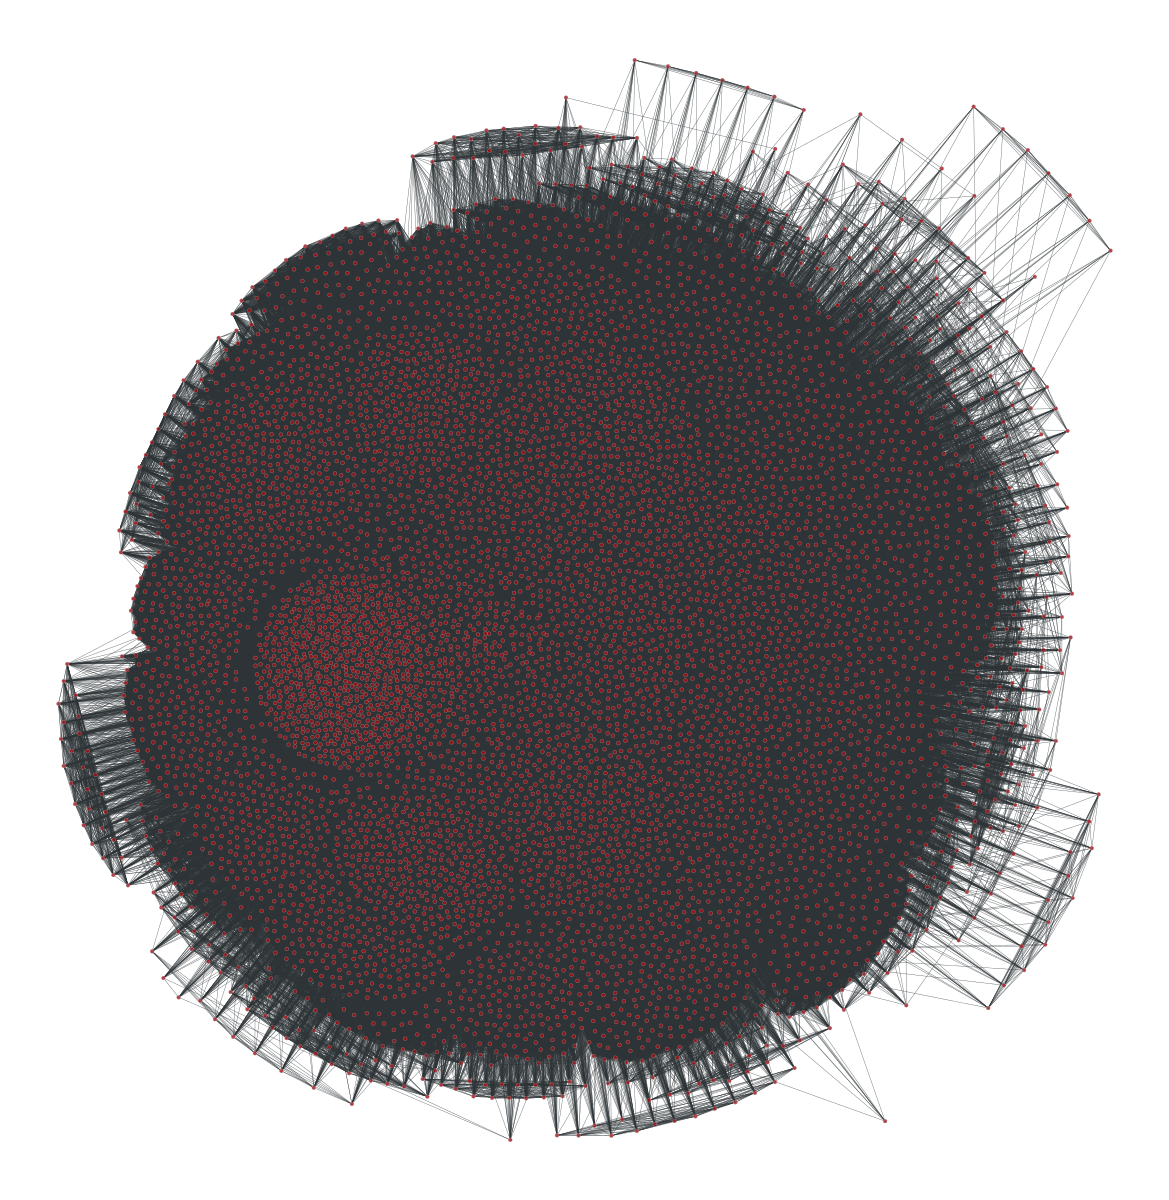

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16a1f5300, at 0x179e31a20>

In [12]:
from graph_tool.draw import sfdp_layout
from graph_tool.draw import graph_draw

pos = sfdp_layout(G)
graph_draw(G, pos)


Processing vertices: 100%|██████████| 8013/8013 [00:12<00:00, 623.92vertex/s]


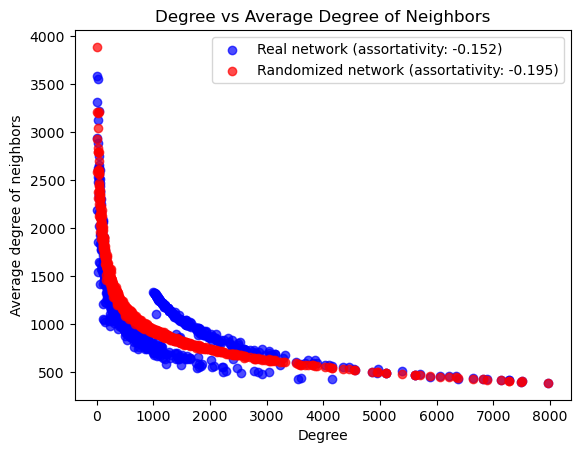

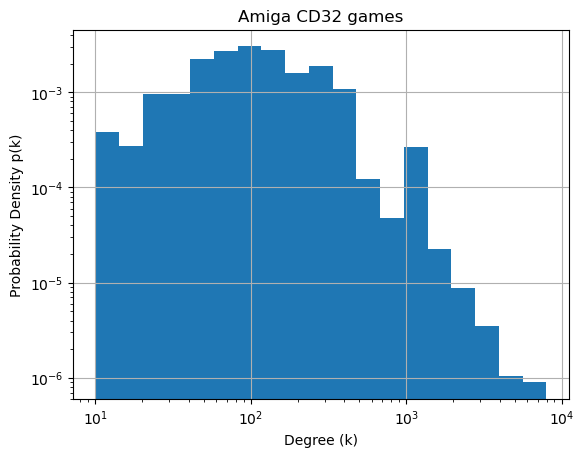

In [4]:
basic_graph_analyzer = BasicGraphAnalyzer(G)
basic_graph_analyzer.plot_degree_vs_avg_degree("Degree vs Average Degree of Neighbors", plot_randomized=True)
basic_graph_analyzer.plot_log_log_probability_density('Amiga CD32 games')

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.05 seconds.

Calculating closeness...
Closeness centrality calculated in 12.35 seconds.

Calculating betweenness...
Betweenness centrality calculated in 18.05 seconds.



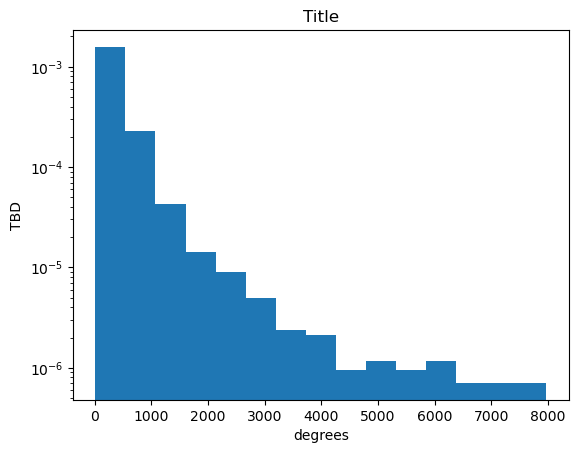

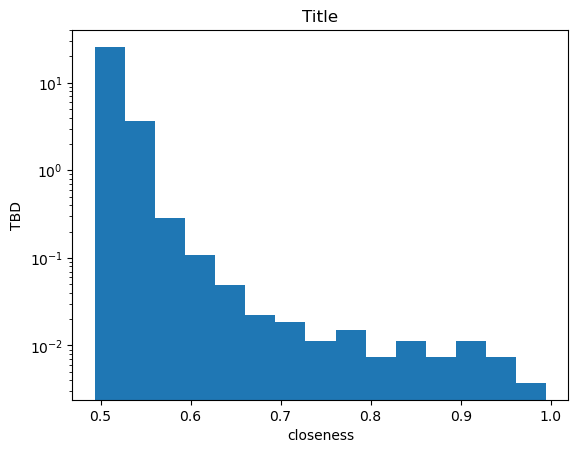

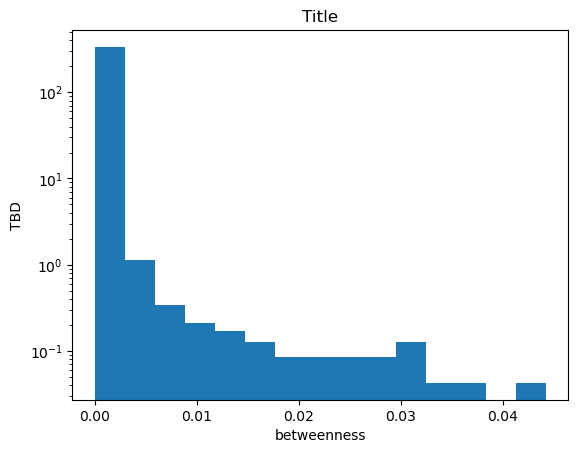

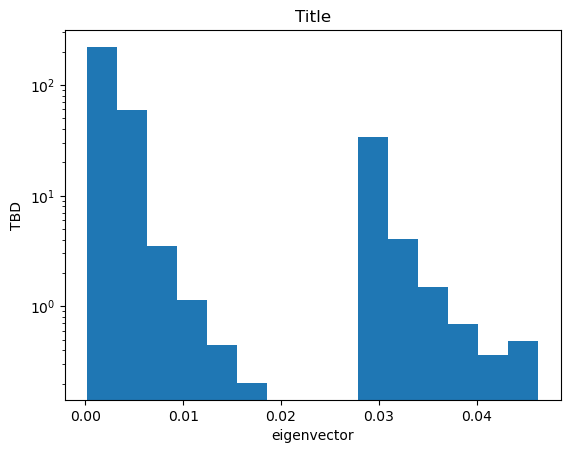

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.04 seconds.

Calculating closeness...
Closeness centrality calculated in 13.95 seconds.

Calculating betweenness...
Betweenness centrality calculated in 18.35 seconds.



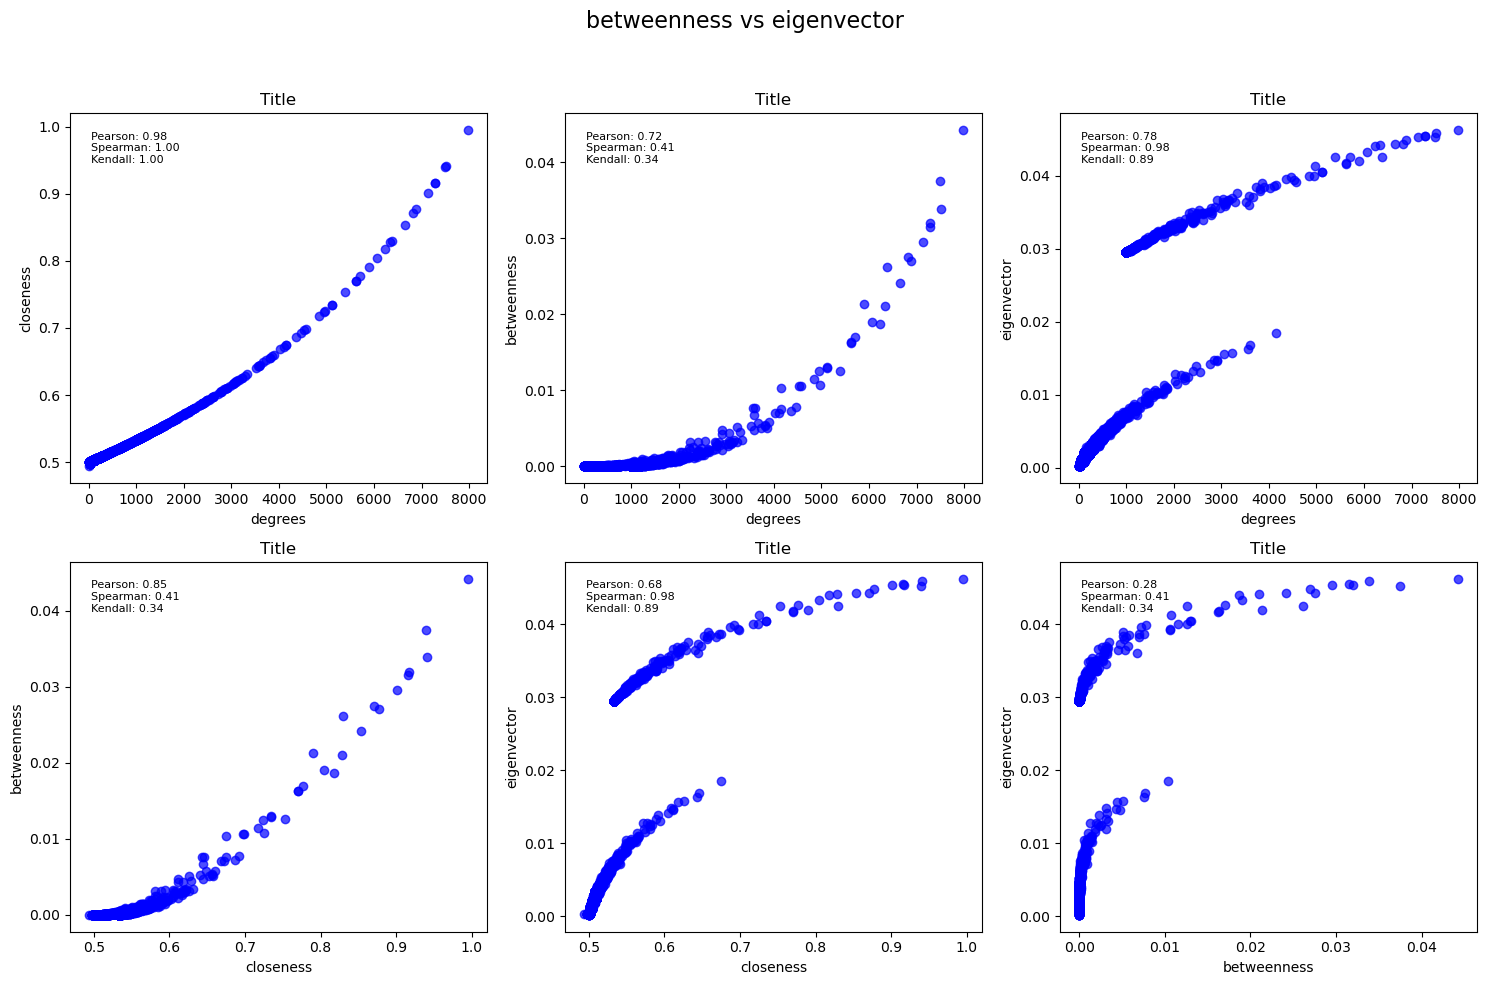

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.06 seconds.

Calculating closeness...
Closeness centrality calculated in 14.44 seconds.

Calculating betweenness...
Betweenness centrality calculated in 20.63 seconds.

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.02 seconds.

Calculating closeness...
Closeness centrality calculated in 15.41 seconds.

Calculating betweenness...
Betweenness centrality calculated in 29.08 seconds.



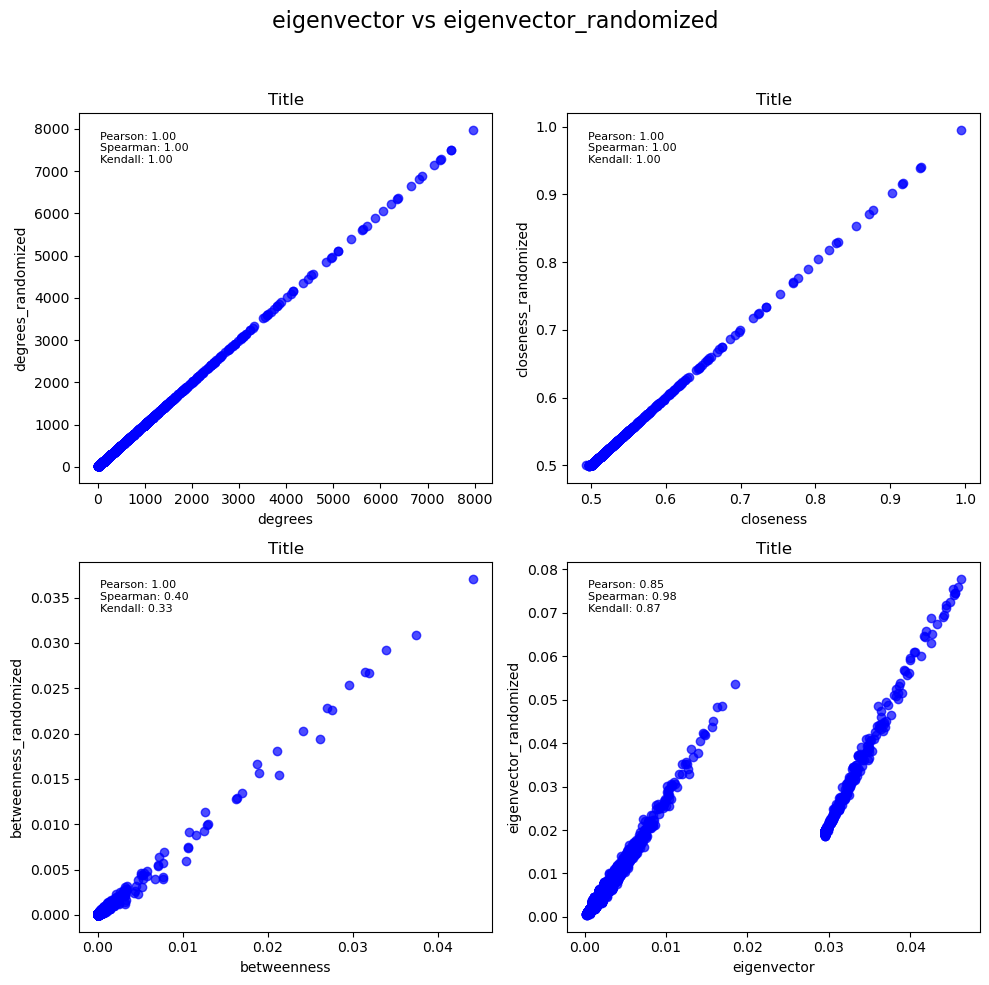

In [5]:
centrality_analyzer = CentralityAnalyzer(G)
centrality_analyzer.plot_centralities()
centrality_analyzer.plot_centralities_comparison()
centrality_analyzer.plot_centralities_comparison_randomized()

In [59]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit

class ScaleFreeAnalyzer:
    def __init__(self, G, is_weighted=False):
        self.G = G
        self.is_weighted = is_weighted
        self.is_filtered = False
        self.filter = None

    def set_filter(self, filter):
        self.is_filtered = True
        self.filter = filter

    def fit_power_law(self, degrees):
        fit = powerlaw.Fit(degrees, discrete=True,)
        return fit.power_law.alpha, fit.power_law.sigma
    
    def calculate_poisson_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def calculate_exponential_degree_distribution(self, degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y
    
    def get_degrees(self, weighted=False):
        if weighted:
            weights = self.G.edge_properties["weight"]
            return [sum(weights[e] for e in v.out_edges()) for v in self.G.vertices()]
        else:
            return self.G.get_out_degrees(self.G.get_vertices())
    
    def calculate_power_law_degree_distribution(self):
        print(50*'-')
        degrees = self.get_degrees(weighted=self.is_weighted)
        if self.is_filtered:
            filtered_degrees = [d for d in degrees if d > self.filter]
            alpha, sigma = self.fit_power_law(filtered_degrees)
        else:
            alpha, sigma = self.fit_power_law(degrees)
        print()
        print()
        print(f'Exponent: {alpha:.3f}')
        print(f'Error: {sigma:.3f}')
        return alpha, sigma

    def plot_degree_distribution(self, title):
        degrees = self.get_degrees(weighted=self.is_weighted)
        title = f"Graph: {title}"
        
        logarithmic_bins = np.logspace(np.log10(max(1, min(degrees))), 
                                    np.log10(max(degrees)), 
                                    num=20)
        
        hist_density, bin_edges = np.histogram(degrees, bins=logarithmic_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        mask = hist_density > 0
        bin_centers = bin_centers[mask]
        hist_density = hist_density[mask]
        
        plt.figure(figsize=(10, 6))
        plt.plot(bin_centers, hist_density, '-o', label='Degree', alpha=0.8)
        
        x, y = self.calculate_poisson_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='g', linestyle='-', label='Poisson Distribution')
        
        x, y = self.calculate_exponential_degree_distribution(degrees, logarithmic_bins)
        plt.plot(x, y, color='b', linestyle='-', label='Exponential Distribution')
        
        degrees_array = np.array(degrees)
        xmin = 1
        if self.is_filtered:
            xmin = self.filter
            filtered_degrees = degrees_array[degrees_array >= self.filter]
        else:
            filtered_degrees = degrees_array
        
        if len(filtered_degrees) > 0:
            fit = powerlaw.Fit(filtered_degrees, discrete=True, xmin=xmin)
            fit.power_law.plot_pdf(color='r', linestyle='--', 
                                label=f'Power Law Fit (α={fit.alpha:.2f})')
        
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([0.001*min(hist_density), 100*max(hist_density)])
        plt.legend()
        plt.title(f'Degree Distribution {title}')
        plt.xlabel('Degree')
        plt.ylabel('Probability Density')
        plt.tight_layout()
        plt.show()
        
        print(f"\nPower Law Analysis:")
        print(f"Minimum degree considered (xmin): {xmin}")
        print(f"Number of nodes in tail: {len(filtered_degrees)}")
        print(f"Power law exponent (α): {fit.alpha:.3f} ± {fit.sigma:.3f}")

/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_40358/1533274147.py:25: RuntimeWarning: overflow encountered in power
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_40358/1533274147.py:25: RuntimeWarning: invalid value encountered in divide
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)


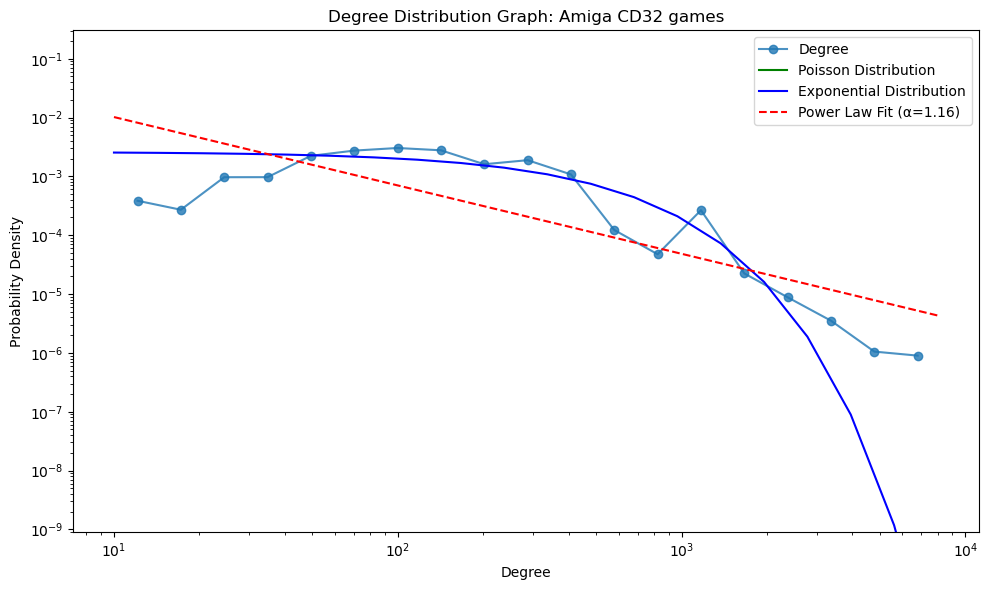


Power Law Analysis:
Minimum degree considered (xmin): 1
Number of nodes in tail: 8013
Power law exponent (α): 1.162 ± 0.002


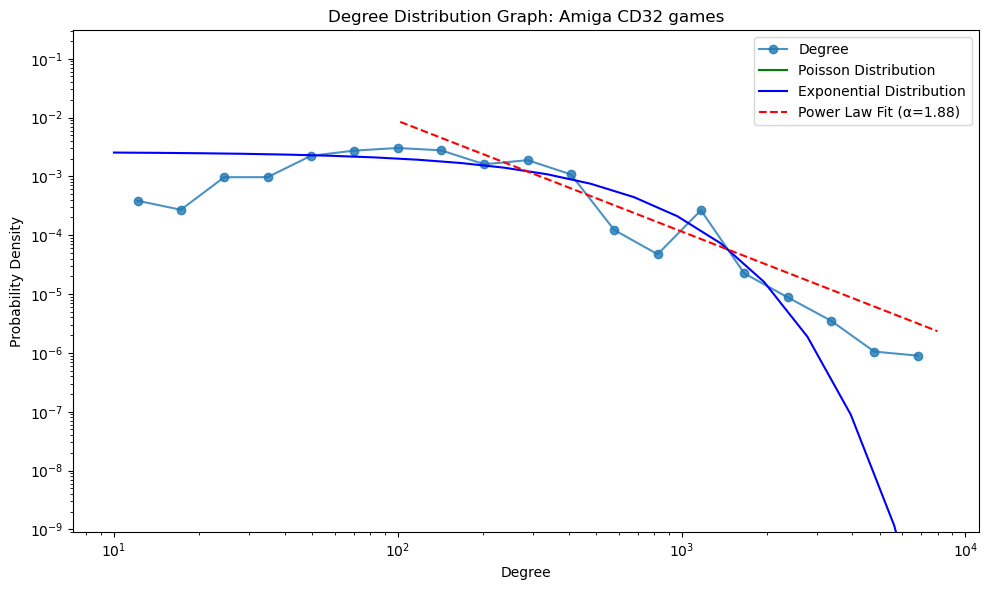


Power Law Analysis:
Minimum degree considered (xmin): 100
Number of nodes in tail: 6705
Power law exponent (α): 1.879 ± 0.011


In [60]:
scale_free_analyzer = ScaleFreeAnalyzer(G)
scale_free_analyzer.plot_degree_distribution('Amiga CD32 games')
scale_free_analyzer.set_filter(10**2)
scale_free_analyzer.plot_degree_distribution('Amiga CD32 games')
